In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import urllib
%matplotlib inline

## Data collection

In [2]:
# GRAPH
for i in range(12):
    query = f"""
        select ?artist_name1 ?artist_name2
        where {{
            select distinct ?artist_name1 ?artist_name2
            where {{
                ?artist1 dbo:associatedMusicalArtist ?artist2 .

                ?artist1 rdfs:label ?artist_name1 ;
                         dbo:genre ?genre_uri1 .

                ?artist2 rdfs:label ?artist_name2 ;
                         dbo:genre ?genre_uri2 .

                filter(lang(?artist_name1)="en")
                filter(lang(?artist_name2)="en")
            }}
            order by ?artist_name1
        }}
        offset {i * 10000}
        limit 10000
    """
    endpoint = "http://dbpedia.org/sparql"

    param = urllib.parse.urlencode({'default-graph-uri': 'http://dbpedia.org', 
                                    'query': query, 
                                    'format': 'text/csv'})
    data = pd.read_csv(endpoint + '?' + param)
    data.to_csv("data/graph{}".format(i+1), index=False)

In [3]:
# GENRES
for i in range(13):
    query = f"""
        select ?artist_name ?genre
        where {{
            select distinct ?artist_name ?genre
            where {{
                {{
                    ?sbj dbo:musicalArtist ?artist .
                }} union {{
                    ?artist dbo:associatedMusicalArtist ?obj .
                }} union {{
                    ?sbj1 dbo:associatedMusicalArtist ?artist .
                }}
                ?artist rdfs:label ?artist_name .

                ?artist dbo:genre ?genre_uri .
                ?genre_uri rdfs:label ?genre .

                filter(lang(?genre)="en")
                filter(lang(?artist_name)="en")
            }}
            order by ?artist_name
        }}
        offset {i * 10000}
        limit 10000
    """
    endpoint = "http://dbpedia.org/sparql"

    param = urllib.parse.urlencode({'default-graph-uri': 'http://dbpedia.org', 
                                    'query': query, 
                                    'format': 'text/csv'})
    data = pd.read_csv(endpoint + '?' + param)
    data.to_csv("data/genre{}".format(i+1), index=False)

In [2]:
dl = list()
for i in range(12):
    dl.append(pd.read_csv("data/graph{}".format(i+1)))
graph_df = pd.concat(dl)
graph_df.sort_values(['artist_name1', 'artist_name2'], inplace=True, kind='mergesort')
graph_df.reset_index(inplace=True)
graph_df.drop(columns=['index'], inplace=True)
display(graph_df)

,artist_name1,artist_name2
0,!!!,LCD Soundsystem
1,!!!,Maserati (band)
2,!!!,Out Hud
3,!!!,The Juan MacLean
4,!!!,Turing Machine (band)
...,...,...
96414,Željko Bebek,Jutro
96415,Željko Joksimović,Dino Merlin
96416,Željko Joksimović,Emina Jahović
96417,Željko Joksimović,Haris Džinović


In [3]:
dl = list()
for i in range(13):
    dl.append(pd.read_csv("data/genre{}".format(i+1)))
genre_df = pd.concat(dl)
del dl
artist_names = list(genre_df.artist_name.unique())
print("The number of unique artist names is: {}".format(len(artist_names)))
display(genre_df)

The number of unique artist names is: 45665


,artist_name,genre
0,!!!,Indie rock
1,!!!,Dance-punk
2,!!!,Post-punk revival
3,"""Weird Al"" Yankovic",Polka
4,"""Weird Al"" Yankovic",Parody music
...,...,...
10528,Șuie Paparude,Electroclash
10529,Șuie Paparude,Dubstep
10530,Șuie Paparude,Breakbeat
10531,Șuie Paparude,Alternative rock


In [5]:
# Make sure that the graph of associated artists contains ONLY those artists that we have genres for
graph_df = graph_df[graph_df.artist_name1.isin(artist_names) & graph_df.artist_name2.isin(artist_names)]

# Update list of artist_names to match the names found in the graph 
artist_names = np.unique(list(graph_df.artist_name1.unique()) + list(graph_df.artist_name2.unique()))

# Make sure the genres table contains ONLY those artists that have a node in the graph 
genre_df = genre_df[genre_df.artist_name.isin(artist_names)]

# Create new genres table containing the artists that don't have a node in the graph, for future testing purposes
nodeless_genre_df = genre_df[~genre_df.artist_name.isin(artist_names)] # Empty table

print("Number of unique artist names after syncing the graph and the table is: {}".format(len(artist_names)))

graph_df.reset_index(inplace=True)
graph_df.drop(columns=['index'], inplace=True)

genre_df.reset_index(inplace=True)
genre_df.drop(columns=['index'], inplace=True)

display(graph_df)
display(genre_df)
display(nodeless_genre_df)

Number of unique artist names after syncing the graph and the table is: 39326


,artist_name1,artist_name2
0,!!!,LCD Soundsystem
1,!!!,Maserati (band)
2,!!!,Out Hud
3,!!!,The Juan MacLean
4,!!!,Turing Machine (band)
...,...,...
83143,Željko Bebek,Jutro
83144,Željko Joksimović,Dino Merlin
83145,Željko Joksimović,Emina Jahović
83146,Željko Joksimović,Haris Džinović


,artist_name,genre
0,!!!,Indie rock
1,!!!,Dance-punk
2,!!!,Post-punk revival
3,"""Weird Al"" Yankovic",Polka
4,"""Weird Al"" Yankovic",Parody music
...,...,...
104996,Željko Joksimović,Dance music
104997,Željko Joksimović,Techno
104998,Željko Joksimović,Pop music
104999,Željko Joksimović,Rock music


,artist_name,genre


In [6]:
def get_unique_genres(verbose=True):
    unique_genres = list()
    for g in genre_df.genre.unique():
        unique_genres.append(str(g))
    if verbose:
        print("The total number of unique genres is: {}".format(len(unique_genres)))
    return sorted(unique_genres)

unique_genres = get_unique_genres()

The total number of unique genres is: 2958


### Manual data cleaning

In [11]:
genre_df.genre.replace(['2 Tone', '2 Tone (music genre)', '2 tone (type of music)'], '2-tone', inplace=True)
genre_df.genre.replace('Acapella', 'A cappella', inplace=True)
genre_df.genre.replace(['Adult Contemporary (chart)', 'Adult Contemporary Music',
                   'Adult Contemporary music'], 'Adult Contemporary', inplace=True)
genre_df.genre.replace(['Adult contemporary', 'Adult contemporary music'], 'Adult Contemporary', inplace=True)
genre_df.genre.replace(['African popular music', 'Afro pop music'], 'Afro Pop', inplace=True)
genre_df.genre.replace('Album-orientated rock', 'Album-oriented rock', inplace=True)
genre_df.genre.replace(['Afrobeats', 'Afro beat'], 'Afrobeat', inplace=True)
genre_df.genre.replace(['Americana (music)', 'Americana music'], 'Americana', inplace=True)
genre_df.genre.replace(['Alt country', 'Alt-Country',
                   'Alt-country'], 'Alternative country', inplace=True)
genre_df.genre.replace(['Alt-rock', 'Alternative rock music'], 'Alternative rock', inplace=True)
genre_df.genre.replace('Anarcho punk', 'Anarcho-punk', inplace=True)
genre_df.genre.replace(['Arab Music', 'Arab music', 'Arabesque music'], 'Arabic music', inplace=True)
genre_df.genre.replace(['Arabic pop music', 'Arabic Pop', 'Arab pop'], 'Arabic pop', inplace=True)
genre_df.genre.replace('Aussie Rock', 'Australian rock', inplace=True)
genre_df.genre.replace('Australian Hip Hop', 'Australian hip hop', inplace=True)
genre_df.genre.replace(['Avant-garde music', 'Avant garde music'], 'Avant-garde', inplace=True)
genre_df.genre.replace(['Axé (music)', 'Axé Music'], 'Axé music', inplace=True)
genre_df.genre.replace('Avant rock', 'Avant-rock', inplace=True)
genre_df.genre.replace('Balkan Music', 'Balkan music', inplace=True)
genre_df.genre.replace('Ballads', 'Ballad', inplace=True)
genre_df.genre.replace(['Banda (music)', 'Banda music'], 'Banda', inplace=True)
genre_df.genre.replace(['Bass (genre)', 'Bass music'], 'Bass', inplace=True)
genre_df.genre.replace('Beat Music', 'Beat music', inplace=True)
genre_df.genre.replace(['Bassline (dance music)', 'Bassline (music genre)'], 'Bassline', inplace=True)
genre_df.genre.replace('Big band music', 'Big band', inplace=True)
genre_df.genre.replace('Blue eyed soul', 'Blue-eyed soul', inplace=True)
genre_df.genre.replace('Blues music', 'Blues', inplace=True)
genre_df.genre.replace('Bluegrass Music', 'Bluegrass music', inplace=True)
genre_df.genre.replace(['Blues Rock', 'Blues rock'], 'Blues-rock', inplace=True)
genre_df.genre.replace('Bubblegum Dance', 'Bubblegum dance', inplace=True)
genre_df.genre.replace('Bubblegum Pop', 'Bubblegum pop', inplace=True)
genre_df.genre.replace('Canzone napoletana', 'Canzone Napoletana', inplace=True)
genre_df.genre.replace(['Chill out', 'Chill-out music'], 'Chill-out', inplace=True)
genre_df.genre.replace('Christian Music', 'Christian music', inplace=True)
genre_df.genre.replace('Classical crossover (musical genre)', 'Classical crossover', inplace=True)
genre_df.genre.replace(['Classical music', 'Classical Music'], 'Classical', inplace=True)
genre_df.genre.replace('Chicago Soul', 'Chicago soul', inplace=True)
genre_df.genre.replace(['Contemporary Christian music', 'Contemporary Christian Music'],
                  'Contemporary Christian', inplace=True)
genre_df.genre.replace('Comedy', 'Comedy music', inplace=True)
genre_df.genre.replace('Contemporary', 'Contemporary music', inplace=True)
genre_df.genre.replace('Contemporary worship', 'Contemporary worship music', inplace=True)
genre_df.genre.replace('Country Rock', 'Country rock', inplace=True)
genre_df.genre.replace(['Country music', 'Country Music'], 'Country', inplace=True)
genre_df.genre.replace('Country-soul', 'Country soul', inplace=True)
genre_df.genre.replace('Crunk music', 'Crunk', inplace=True)
genre_df.genre.replace('Crossover (music)', 'Crossover music', inplace=True)
genre_df.genre.replace('Cover version', 'Cover band', inplace=True)
genre_df.genre.replace(['Dance (music)', 'Dance Music', 'Dance'], 'Dance music', inplace=True)
genre_df.genre.replace('Dance pop', 'Dance-pop', inplace=True)
genre_df.genre.replace('Dance rock', 'Dance-rock', inplace=True)
genre_df.genre.replace('Dark Ambient', 'Dark ambient', inplace=True)
genre_df.genre.replace('Deep House', 'Deep house', inplace=True)
genre_df.genre.replace('Doo wop', 'Doo-wop', inplace=True)
genre_df.genre.replace('Death-doom', 'Death/doom', inplace=True)
genre_df.genre.replace('Disco House', 'Disco house', inplace=True)
genre_df.genre.replace(['Disco Music', 'Disco'], 'Disco music', inplace=True)
genre_df.genre.replace(['Drum and bass', 'Drum and Bass', 'Drum & Bass'], 'Drum & bass', inplace=True)
genre_df.genre.replace('Drone (music)', 'Drone music', inplace=True)
genre_df.genre.replace('Electro (music)', 'Electro music', inplace=True)
genre_df.genre.replace('Easy listening', 'Easy-listening', inplace=True)
genre_df.genre.replace('Electro House', 'Electro house', inplace=True)
genre_df.genre.replace('Electro Industrial', 'Electro-industrial', inplace=True)
genre_df.genre.replace('Electro funk', 'Electro-funk', inplace=True)
genre_df.genre.replace('Electro Swing', 'Electro-swing', inplace=True)
genre_df.genre.replace(['Electro house', 'Electro-House'], 'Electro-house', inplace=True)
genre_df.genre.replace(['Electro hop music', 'Electro hop'], 'Electro-hop', inplace=True)
genre_df.genre.replace(['Electronic (music)', 'Electronic Music'], 'Electronic music', inplace=True)
genre_df.genre.replace(['Electronic Dance Music', 'Electronic Dance music',
                  'Electronic dance music'], 'Electronic dance', inplace=True)
genre_df.genre.replace('Electronica music', 'Electronica', inplace=True)
genre_df.genre.replace('Electropop', 'Electro-pop', inplace=True)
genre_df.genre.replace('Electropunk', 'Electro-punk', inplace=True)
genre_df.genre.replace('Emo', 'Emo music', inplace=True)
genre_df.genre.replace('Emo pop', 'Emo-pop', inplace=True)
genre_df.genre.replace('Euro disco', 'Eurodisco', inplace=True)
genre_df.genre.replace('Euro house', 'Eurohouse', inplace=True)
genre_df.genre.replace('Euro-pop', 'Europop', inplace=True)
genre_df.genre.replace('Experimental music', 'Experimental', inplace=True)
genre_df.genre.replace('Experimental Rock', 'Experimental rock', inplace=True)
genre_df.genre.replace('Film', 'Film music', inplace=True)
genre_df.genre.replace('Film scores', 'Film score', inplace=True)
genre_df.genre.replace(['Electronic (music)', 'Electronic Music'], 'Electronic music', inplace=True)

unique_genres = get_unique_genres()

The total number of unique genres is: 2855


### Regex data cleaning

In [13]:
genre_df.genre = genre_df.genre.str.lower()
genre_df.genre.replace("[ -\.]", "_", regex=True, inplace=True)
genre_df.genre.replace("__*", "_", regex=True, inplace=True)
genre_df.genre.replace("_$", "", regex=True, inplace=True)
genre_df.genre.replace("_music$", "", regex=True, inplace=True)
genre_df.genre.replace("_\(music\)$", "", regex=True, inplace=True)
genre_df.genre.replace("_\(songs\)$", "", regex=True, inplace=True)
genre_df.genre.replace("_songs$", "", regex=True, inplace=True)
genre_df.genre.replace("_\(album\)$", "", regex=True, inplace=True)
genre_df.genre.replace("_album$", "", regex=True, inplace=True)
genre_df.genre.replace("_band$", "", regex=True, inplace=True)
genre_df.genre.replace("_\(band\)$", "", regex=True, inplace=True)
genre_df.genre.replace("_genre$", "", regex=True, inplace=True)
genre_df.genre.replace("_\(genre\)$", "", regex=True, inplace=True)
genre_df.genre.replace("video_game", 'video_game_soundtracks', inplace=True)
genre_df.genre.replace("a_capella", 'a_cappella', inplace=True)
genre_df.genre.replace("antifolk", 'anti_folk', inplace=True)
genre_df.genre.replace("big_bands", 'big_band', inplace=True)
genre_df.genre.replace("breakdancing", 'breakdance', inplace=True)
genre_df.genre.replace("black_doom", 'black/doom', inplace=True)

unique_genres = get_unique_genres()

The total number of unique genres is: 2125


### Manual cleaning 2.0

In [16]:
genre_df.genre.replace(['singer/songwriter', 'singer–songwriter'], 'singer_songwriter', inplace=True)
genre_df.genre.replace(['afro_beat','afro_beats'], 'afrobeat', inplace=True)
genre_df.genre.replace(['alternative_country'], 'alt_country', inplace=True)
genre_df.genre.replace(['alternative_rock'], 'alt_rock', inplace=True)
genre_df.genre.replace(['argentine_rock'], 'argentinian_rock', inplace=True)
genre_df.genre.replace(['artrock'], 'art_rock', inplace=True)
genre_df.genre.replace(['author_s_song','author_song'], 'author', inplace=True)
genre_df.genre.replace(['avantgarde'], 'avant_garde', inplace=True)
genre_df.genre.replace(['british_r_b', 'british_rhythm_and_blues'], 'british_rnb', inplace=True)
genre_df.genre.replace(['avant_garde_jazz'], 'avant_jazz', inplace=True)
genre_df.genre.replace(['broadway_musicals'], 'broadway_musical', inplace=True)
genre_df.genre.replace(['bossanova'], 'bossa_nova', inplace=True)
genre_df.genre.replace(['brit_pop'], 'britpop', inplace=True)
genre_df.genre.replace(['brazil', 'brasil'], 'brazilian', inplace=True)
genre_df.genre.replace(['be_bop'], 'bebop', inplace=True)
genre_df.genre.replace(['broadway_theater'], 'broadway_theatre', inplace=True)
genre_df.genre.replace(['avant_garde_rock'], 'avant_rock', inplace=True)
genre_df.genre.replace(['avantgarde_metal', 'avant_garde_metal'], 'avant_metal', inplace=True)
genre_df.genre.replace(['bulgarian_folklore'], 'bulgarian_folk', inplace=True)
genre_df.genre.replace(['children_s', 'children_s_song'], 'children', inplace=True)
genre_df.genre.replace(['chillout'], 'chill_out', inplace=True)
genre_df.genre.replace(['choirs'], 'choir', inplace=True)
genre_df.genre.replace(['chopped_screwed'], 'chopped_and_screwed', inplace=True)
genre_df.genre.replace(['chorinho'], 'choro', inplace=True)
genre_df.genre.replace(['christian_rap'], 'christian_hip_hop', inplace=True)
genre_df.genre.replace(['coldwave'], 'cold_wave', inplace=True)
genre_df.genre.replace(['comedy_rap'], 'comedy_hip_hop', inplace=True)
genre_df.genre.replace(['conscious_rap'], 'conscious_hip_hop', inplace=True)
genre_df.genre.replace(['cross'], 'crossover', inplace=True)
genre_df.genre.replace(['darkwave'], 'dark_wave', inplace=True)
genre_df.genre.replace(['dreampop'], 'dream_pop', inplace=True)
genre_df.genre.replace(['contemporary_r_b', 'contemporary_rhythm_and_blues'], 'contemporary_rnb', inplace=True)
genre_df.genre.replace(['drum_bass'], 'drum_n_bass', inplace=True)
genre_df.genre.replace(['east_coast_rap'], 'east_coast_hip_hop', inplace=True)
genre_df.genre.replace(['electro','list_of_electronic_music_genres'], 'electronic', inplace=True)
genre_df.genre.replace(['electronic_jazz'], 'electro_jazz', inplace=True)
genre_df.genre.replace(['electronic_punk'], 'electro_punk', inplace=True)
genre_df.genre.replace(['electronic_rock'], 'electro_rock', inplace=True)
genre_df.genre.replace(['electronic_pop', 'electropop'], 'electro_pop', inplace=True)
genre_df.genre.replace(['emo_core'], 'emocore', inplace=True)
genre_df.genre.replace(['english_people', 'england'], 'english', inplace=True)
genre_df.genre.replace(['expressionism'], 'expressionist', inplace=True)
genre_df.genre.replace(['fiddling'], 'fiddle', inplace=True)
genre_df.genre.replace(['filin'], 'filín', inplace=True)
genre_df.genre.replace(['fingerstyle_guitar'], 'fingerstyle', inplace=True)
genre_df.genre.replace(['film_scores'], 'film_score', inplace=True)
genre_df.genre.replace(['folk_albums'], 'folk', inplace=True)
genre_df.genre.replace(['folk_music_of_punjab'], 'punjabi_folk', inplace=True)
genre_df.genre.replace(['free_improvisation'], 'free_improv', inplace=True)
genre_df.genre.replace(['freestyle_rap'], 'freestyle', inplace=True)
genre_df.genre.replace(['french_rap'], 'french_hip_hop', inplace=True)
genre_df.genre.replace(['funeral_doom'], 'funeral_doom_metal', inplace=True)
genre_df.genre.replace(['futurepop'], 'future_pop', inplace=True)
genre_df.genre.replace(['funktronica'], 'funktronic', inplace=True)
genre_df.genre.replace(['gangster_rap'], 'gangsta_rap', inplace=True)
genre_df.genre.replace(['garage_music_north_america', 'garage_music_us_garage'], 'garage_music_usa', inplace=True)
genre_df.genre.replace(['german_rap'], 'german_hip_hop', inplace=True)
genre_df.genre.replace(['ghazals'], 'ghazal', inplace=True)
genre_df.genre.replace(['gothic'], 'goth', inplace=True)
genre_df.genre.replace(['gothic_metal'], 'goth_metal', inplace=True)
genre_df.genre.replace(['gothic_rock'], 'goth_rock', inplace=True)
genre_df.genre.replace(['german_language', 'germany', 'germans'], 'german', inplace=True)
genre_df.genre.replace(['hardbop'], 'hard_bop', inplace=True)
genre_df.genre.replace(['hardcore_rap'], 'hardcore_hip_hop', inplace=True)
genre_df.genre.replace(['hi_life','highlife'], 'high_life', inplace=True)
genre_df.genre.replace(['bollywood', 'music_of_bollywood'], 'hindi', inplace=True)
genre_df.genre.replace(['hiplife'], 'hip_life', inplace=True)
genre_df.genre.replace(['improvisation','improvisational'], 'improvised', inplace=True)
genre_df.genre.replace(['indian_people'], 'indian', inplace=True)
genre_df.genre.replace(['indipop','indian_pop'], 'indi_pop', inplace=True)
genre_df.genre.replace(['indiepop'], 'indie_pop', inplace=True)
genre_df.genre.replace(['jam_bands'], 'jam', inplace=True)
genre_df.genre.replace(['jpop','j_pop'], 'japanese_pop', inplace=True)
genre_df.genre.replace(['jazz_rock'], 'jazzrock', inplace=True)
genre_df.genre.replace(['juju'], 'jùjú', inplace=True)
genre_df.genre.replace(['kemençe_of_the_black_sea'], 'kemençe', inplace=True)
genre_df.genre.replace(['k_hiphop'], 'korean_hip_hop', inplace=True)
genre_df.genre.replace(['kpop','korean_pop'], 'k_pop', inplace=True)
genre_df.genre.replace(['krautrock'], 'kraut_rock', inplace=True)
genre_df.genre.replace(['latin_rap'], 'latin_hip_hop', inplace=True)
genre_df.genre.replace(['latin_music,latin_american'], 'latin', inplace=True)
genre_df.genre.replace(['laïka','laïko','laïkó'], 'laiko', inplace=True)
genre_df.genre.replace(['list_of_blues_genres'], 'blues', inplace=True)
genre_df.genre.replace(['list_of_christian_country_artists'], 'christian_country', inplace=True)
genre_df.genre.replace(['list_of_electronic_music_genres'], 'korean_hip_hop', inplace=True)
genre_df.genre.replace(['lover_s_rock'], 'lovers_rock', inplace=True)
genre_df.genre.replace(['mangue_bit'], 'manguebeat', inplace=True)
genre_df.genre.replace(['marching'], 'march', inplace=True)
genre_df.genre.replace(['midwest_rap'], 'midwest_hip_hop', inplace=True)
genre_df.genre.replace(['minimalist','minimal'], 'minimalism', inplace=True)
genre_df.genre.replace(['motown_sound'], 'motown', inplace=True)
genre_df.genre.replace(['mpb:_brazilian_popular', 'mpb_música_popular_brasileira',
                        'música_popular_brasileira'], 'musica_popular_brasileira', inplace=True)
genre_df.genre.replace(['republic_of_the_congo','democratic_republic_of_the_congo',
                        'music_of_the_democratic_republic_of_the_congo'], 'congo_music', inplace=True)
genre_df.genre.replace(['musical_theater'], 'musical_theatre', inplace=True)
genre_df.genre.replace(['musique_concrète','musique_concréte'], 'musique_concrete', inplace=True)
genre_df.genre.replace(['neoclassical_metal'], 'neo_classical_metal', inplace=True)
genre_df.genre.replace(['neo_progressive_rock'], 'neo_prog', inplace=True)
genre_df.genre.replace(['neoclassical','neoclassicism'], 'neo_classical', inplace=True)
genre_df.genre.replace(['neoclassical_dark_wave'], 'neoclassical_darkwave', inplace=True)
genre_df.genre.replace(['new_primitives'], 'new_primitivism', inplace=True)
genre_df.genre.replace(['new_romantic'], 'new_romanticism', inplace=True)
genre_df.genre.replace(['noise_pop'], 'noisepop', inplace=True)
genre_df.genre.replace(['novelty_record','novelty_song'], 'novelty', inplace=True)
genre_df.genre.replace(['nueva_canción'], 'nueva_cancion', inplace=True)
genre_df.genre.replace(['old_school_rap'], 'old_school_hip_hop', inplace=True)
genre_df.genre.replace(['orchestrated','orchestra'], 'orchestral', inplace=True)
genre_df.genre.replace(['p_pop'], 'pinoy_pop', inplace=True)
genre_df.genre.replace(['alternative_r_b,pbr_b'], 'alternative_r_n_b', inplace=True)
genre_df.genre.replace(['philadelphia_soul'], 'philly_soul', inplace=True)
genre_df.genre.replace(['playback_singer'], 'playback_singing', inplace=True)
genre_df.genre.replace(['poetry_slam'], 'poetry', inplace=True)
genre_df.genre.replace(['political_rap'], 'political_hip_hop', inplace=True)
genre_df.genre.replace(['pop_standards'], 'pop_standard', inplace=True)
genre_df.genre.replace(['poprock','pop/rock'], 'pop_rock', inplace=True)
genre_df.genre.replace(['popular','popular_song'], 'pop', inplace=True)
genre_df.genre.replace(['post_industrial_music_genres_and_related_fusion_genres'], 'post_industrial', inplace=True)
genre_df.genre.replace(['post_progressive'], 'post_prog', inplace=True)
genre_df.genre.replace(['postrock'], 'post_rock', inplace=True)
genre_df.genre.replace(['postmodernism'], 'postmodern', inplace=True)
genre_df.genre.replace(['power_ballads'], 'power_ballad', inplace=True)
genre_df.genre.replace(['powernoise'], 'power_noise', inplace=True)
genre_df.genre.replace(['powerpop'], 'power_pop', inplace=True)
genre_df.genre.replace(['powerviolence'], 'power_violence', inplace=True)
genre_df.genre.replace(['progressive_jazz'], 'prog_jazz', inplace=True)
genre_df.genre.replace(['progressive_rock'], 'prog_rock', inplace=True)
genre_df.genre.replace(['progressive_electronic_dance'], 'progressive_edm', inplace=True)
genre_df.genre.replace(['protest_song'], 'protest', inplace=True)
genre_df.genre.replace(['proto_punk'], 'protopunk', inplace=True)
genre_df.genre.replace(['psychedelic_folk'], 'psych_folk', inplace=True)
genre_df.genre.replace(['psychedelic_rock'], 'psych_rock', inplace=True)
genre_df.genre.replace(['psychedelia'], 'psychedelic', inplace=True)
genre_df.genre.replace(['psychedelic_trance'], 'psytrance', inplace=True)
genre_df.genre.replace(['punjabi_culture','punjabi_language',
                        'punjabi_people,music_of_punjab'], 'punjabi', inplace=True)
genre_df.genre.replace(['punkrock'], 'punk_rock', inplace=True)
genre_df.genre.replace(['progressive_electronic_dance'], 'progressive_edm', inplace=True)
genre_df.genre.replace(['r_b'], 'r_n_b', inplace=True)
genre_df.genre.replace(['ranchera'], 'rancheras', inplace=True)
genre_df.genre.replace(['rapper','rapping'], 'rap', inplace=True)
genre_df.genre.replace(['reggea','raggae'], 'reggae', inplace=True)
genre_df.genre.replace(['reggaetón'], 'reggaeton', inplace=True)
genre_df.genre.replace(['retro_style'], 'retro', inplace=True)
genre_df.genre.replace(['rhythm_and_blues','rhythm_blues'], 'r_n_b', inplace=True)
genre_df.genre.replace(['riot_grrrl','riotgrrl'], 'riot_grrl', inplace=True)
genre_df.genre.replace(['rock_en_español'], 'rock_en_espanol', inplace=True)
genre_df.genre.replace(['rock_roll','rock_and_roll'], 'rock_n_roll', inplace=True)
genre_df.genre.replace(['romantic'], 'romance', inplace=True)
genre_df.genre.replace(['scat_singing'], 'scat', inplace=True)
genre_df.genre.replace(['screwed_chopped'], 'screwed_and_chopped', inplace=True)
genre_df.genre.replace(['shoegaze','shoegazer'], 'shoegazing', inplace=True)
genre_df.genre.replace(['show_tunes'], 'show_tune', inplace=True)
genre_df.genre.replace(['slow_jams'], 'slow_jam', inplace=True)
genre_df.genre.replace(['soundtracks'], 'soundtrack', inplace=True)
genre_df.genre.replace(['third_wave_ska'], 'third_wave_of_ska', inplace=True)
genre_df.genre.replace(['thumris'], 'thumri', inplace=True)
genre_df.genre.replace(['skacore'], 'ska_core', inplace=True)
genre_df.genre.replace(['torch_singer','torch_song'], 'torch', inplace=True)
genre_df.genre.replace(['traditional_popular'], 'traditional_pop', inplace=True)
genre_df.genre.replace(['theatrical'], 'theatre', inplace=True)
genre_df.genre.replace(['trap_music'], 'trap', inplace=True)
genre_df.genre.replace(['trance_music'], 'trance', inplace=True)
genre_df.genre.replace(['turbofolk'], 'turbo_folk', inplace=True)
genre_df.genre.replace(['turkish_music_style'], 'turkish', inplace=True)
genre_df.genre.replace(['western_music_north_america'], 'western', inplace=True)
genre_df.genre.replace(['witch_house_music'], 'witch_house', inplace=True)
genre_df.genre.replace(['worldbeat'], 'world_beat', inplace=True)
genre_df.genre.replace(['zamba_artform'], 'zamba', inplace=True)
genre_df.genre.replace(['westcoast_hip_hop','west_coast_rap'], 'west_coast_hip_hop', inplace=True)
genre_df.genre.replace(['tuvan_throat_singing'], 'tuvan', inplace=True)
genre_df.genre.replace(['video_game_soundtracks'], 'video_game_score', inplace=True)
genre_df.genre.replace(['vocal'], 'vocals', inplace=True)

unique_genres = get_unique_genres()

The total number of unique genres is: 1924


### Create the genres table

In [17]:
dummies = pd.get_dummies(genre_df.genre)
dummies['artist_name'] = genre_df.artist_name
dummies.drop_duplicates(inplace=True)
display(dummies)

,20th_century,20th_century_classical,21st_century_classical,2_step_garage,2_tone,a_cappella,abakuá,aboriginal,aboriginal_rock,absolute,...,zamba,zef,zeuhl,zimbabwean,zouglou,zouk,zulu,zydeco,éntekhno,artist_name
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,!!!
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,!!!
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,!!!
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"""Weird Al"" Yankovic"
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"""Weird Al"" Yankovic"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Željko Joksimović
104997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Željko Joksimović
104998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Željko Joksimović
104999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Željko Joksimović


In [20]:
genre_df = dummies.groupby(['artist_name']).sum()
genre_df.reset_index(inplace=True)
# genre_df.drop(columns=['index'], inplace=True)
display(genre_df)

,artist_name,20th_century,20th_century_classical,21st_century_classical,2_step_garage,2_tone,a_cappella,abakuá,aboriginal,aboriginal_rock,...,yé_yé,zamba,zef,zeuhl,zimbabwean,zouglou,zouk,zulu,zydeco,éntekhno
0,!!!,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"""Weird Al"" Yankovic",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,'68 Comeback,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,'O' Level,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,'Til Tuesday,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39321,Škan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39322,Žagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39323,Žanil Tataj - Žak,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39324,Željko Bebek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Remove duplicate links in the graph

CAUTION: Very slow!

In [22]:
graph = pd.DataFrame(columns=['artist_name1', 'artist_name2'])
i = 0
for x in graph_df.values:
    if not (((graph['artist_name1'] == x[0]) & (graph['artist_name2'] == x[1])).any() or 
           ((graph['artist_name2'] == x[0]) & (graph['artist_name1'] == x[1])).any()):
        graph.loc[i] = x
        i += 1

print(np.shape(graph))
print(np.shape(graph_df))
display(graph)

(73151, 2)
(83148, 2)


,artist_name1,artist_name2
0,!!!,LCD Soundsystem
1,!!!,Maserati (band)
2,!!!,Out Hud
3,!!!,The Juan MacLean
4,!!!,Turing Machine (band)
...,...,...
73146,Žanil Tataj - Žak,Divlje jagode
73147,Željko Bebek,Jutro
73148,Željko Joksimović,Emina Jahović
73149,Željko Joksimović,Haris Džinović


### Save both graph and genre table as csv files for later use

In [25]:
genre_df.to_csv("genres.csv", index=False)
graph.to_csv("graph.csv", index=False)

del graph
del dummies

In [13]:
genre_df = pd.read_csv("genres.csv")
graph_df = pd.read_csv("graph.csv")

## Further cleaning of the data

In [14]:
num_artist_per_genre = [genre_df[col].sum() for col in genre_df.columns[1:]]
num_genres_per_artist = [np.sum(x[1:]) for x in genre_df.values]

In [80]:
num_genres_1_artist = 0
num_genres_no_artist = 0

for x in num_artist_per_genre:
    if x == 1:
        num_genres_1_artist += 1
    elif x == 0:
        num_genres_no_artist += 1

print("The number of genres having only 1 artist is {}".format(num_genres_1_artist))
print("The number of genres having no artist is {}\n".format(num_genres_no_artist))

print("The largest 5 genres have the following numbers of artists: {}".format(
    sorted(num_artist_per_genre, reverse=True)[:5]))

The number of genres having only 1 artist is 607
The number of genres having no artist is 0

The largest 5 genres have the following numbers of artists: [4326, 4185, 4128, 3472, 2980]


### Drop all genres that have only 1 artist

In [82]:
columns_to_drop = []
for i, num in enumerate(num_artist_per_genre):
    if num == 1:
        columns_to_drop.append(genre_df.columns[i+1])
# print(columns_to_drop)
genre_df.drop(columns=columns_to_drop, inplace=True)

# Check if any artists are left with no genres
num_genres_per_artist = [np.sum(x[1:]) for x in genre_df.values]
zero_genre_artists = 0
for x in num_genres_per_artist:
    if x == 0:
        zero_genre_artists += 1
print("The number of artists left without a genre is: {}".format(zero_genre_artists))

The number of artists left without a genre is: 61


### Drop all artists that have no genre

In [84]:
rows_to_drop = []
for i, num in enumerate(num_genres_per_artist):
    if num == 0:
        rows_to_drop.append(i)
# print(rows_to_drop)
no_genre_artists = [genre_df.iloc[x].artist_name for x in rows_to_drop]
genre_df.drop(index=rows_to_drop, inplace=True)
genre_df.reset_index(inplace=True)
genre_df.drop(columns=['index'], inplace=True)

# Check once more if there are any genres with one or no artists
num_artist_per_genre = [genre_df[col].sum() for col in genre_df.columns[1:]]
num_genres_1_artist = 0
num_genres_no_artist = 0

for x in num_artist_per_genre:
    if x == 1:
        num_genres_1_artist += 1
    elif x == 0:
        num_genres_no_artist += 1

print("The number of genres having only 1 artist is {}".format(num_genres_1_artist))
print("The number of genres having no artist is {}".format(num_genres_no_artist))

The number of genres having only 1 artist is 0
The number of genres having no artist is 0


### Drop those 61 artists from the graph too

In [97]:
for i, x in enumerate(graph_df.values):
    if x[0] in no_genre_artists or x[1] in no_genre_artists:
        graph_df.drop(index=i, inplace=True)
graph_df.reset_index(inplace=True)
graph_df.drop(columns=['index'], inplace=True)
display(graph_df)

,artist_name1,artist_name2
0,!!!,LCD Soundsystem
1,!!!,Maserati (band)
2,!!!,Out Hud
3,!!!,The Juan MacLean
4,!!!,Turing Machine (band)
...,...,...
73034,Žanil Tataj - Žak,Divlje jagode
73035,Željko Bebek,Jutro
73036,Željko Joksimović,Emina Jahović
73037,Željko Joksimović,Haris Džinović


In [99]:
# Update list of artist_names to match the names found in the graph 
artist_names = np.unique(list(graph_df.artist_name1.unique()) + list(graph_df.artist_name2.unique()))

# Make sure the genres table contains ONLY those artists that have a node in the graph 
genre_df = genre_df[genre_df.artist_name.isin(artist_names)]

# Create new genres table containing the artists that don't have a node in the graph, for future testing purposes
nodeless_genre_df = genre_df[~genre_df.artist_name.isin(artist_names)] # Empty table

print("Number of unique artist names after syncing the graph and the table is: {}".format(len(artist_names)))

genre_df.reset_index(inplace=True)
genre_df.drop(columns=['index'], inplace=True)

display(genre_df)
display(nodeless_genre_df)

Number of unique artist names after syncing the graph and the table is: 39244


,artist_name,20th_century,20th_century_classical,21st_century_classical,2_step_garage,2_tone,a_cappella,aboriginal_rock,abstract,abstract_hip_hop,...,worship,yoruba,youth_crew,yé_yé,zamba,zef,zeuhl,zouk,zulu,zydeco
0,!!!,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"""Weird Al"" Yankovic",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,'68 Comeback,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,'O' Level,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,'Til Tuesday,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39239,Škan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39240,Žagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39241,Žanil Tataj - Žak,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39242,Željko Bebek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,artist_name,20th_century,20th_century_classical,21st_century_classical,2_step_garage,2_tone,a_cappella,aboriginal_rock,abstract,abstract_hip_hop,...,worship,yoruba,youth_crew,yé_yé,zamba,zef,zeuhl,zouk,zulu,zydeco


### Check once more 

In [101]:
# Check once more if there are any genres with one or no artists
num_artist_per_genre = [genre_df[col].sum() for col in genre_df.columns[1:]]
num_genres_1_artist = 0
num_genres_no_artist = 0

for x in num_artist_per_genre:
    if x == 1:
        num_genres_1_artist += 1
    elif x == 0:
        num_genres_no_artist += 1

print("The number of genres having only 1 artist is {}".format(num_genres_1_artist))
print("The number of genres having no artist is {}".format(num_genres_no_artist))

The number of genres having only 1 artist is 0
The number of genres having no artist is 0


In [102]:
genre_df.to_csv("genres.csv", index=False)
graph_df.to_csv("graph.csv", index=False)

## Visualizations

In [4]:
genre_df = pd.read_csv("genres.csv")
graph_df = pd.read_csv("graph.csv")

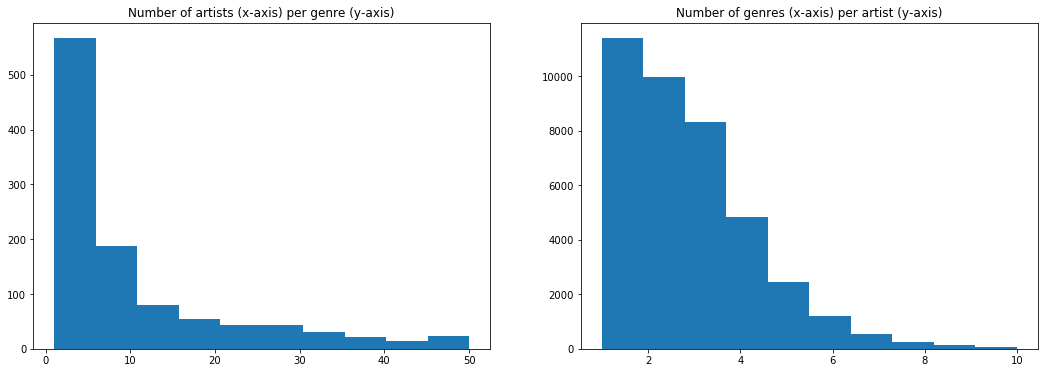

In [5]:
num_artist_per_genre = [genre_df[col].sum() for col in genre_df.columns[1:]]
num_genres_per_artist = [np.sum(x[1:]) for x in genre_df.values]

fig = plt.figure(figsize=(18,6))
fig.subplots(1,2)

plt.subplot(1,2,1)
plt.title("Number of artists (x-axis) per genre (y-axis)")
plt.hist(num_artist_per_genre, range=(1,50))

plt.subplot(1,2,2)
plt.title("Number of genres (x-axis) per artist (y-axis)")
plt.hist(num_genres_per_artist, range=(1,10))

plt.show()

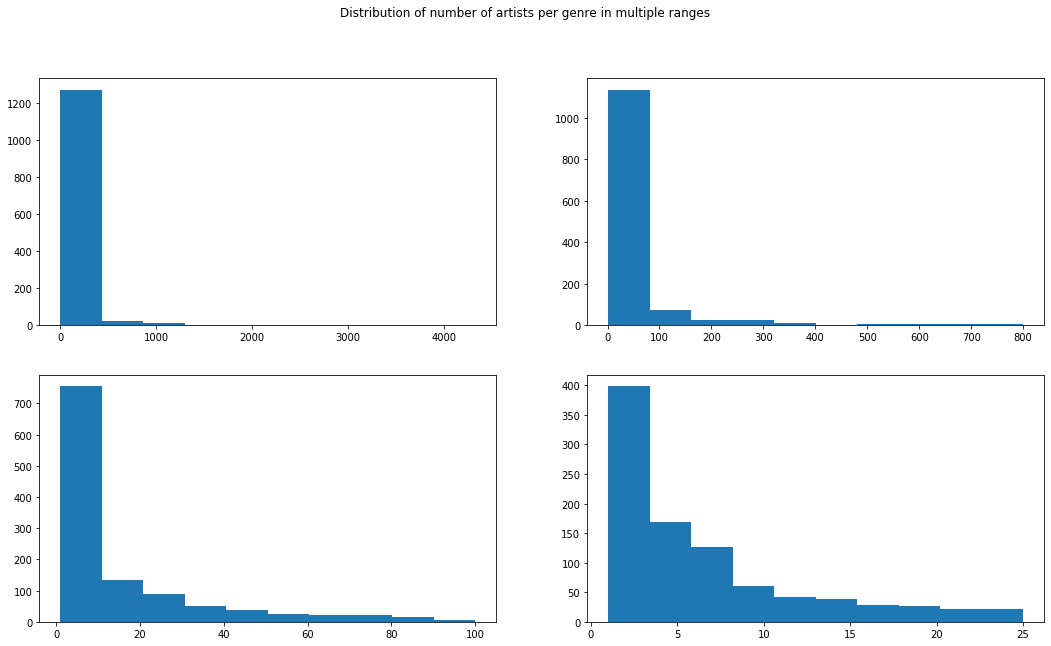

In [3]:
num_artist_per_genre = [genre_df[col].sum() for col in genre_df.columns[1:]]

fig = plt.figure(figsize=(18,10))
fig.subplots(2,2)
ranges = [(1,max(num_artist_per_genre)), (1, 800), (1, 100), (1, 25)]
for x in range(4):
    plt.subplot(2,2,x+1)
    plt.hist(num_artist_per_genre, range=ranges[x])
fig.suptitle("Distribution of number of artists per genre in multiple ranges")
plt.show()

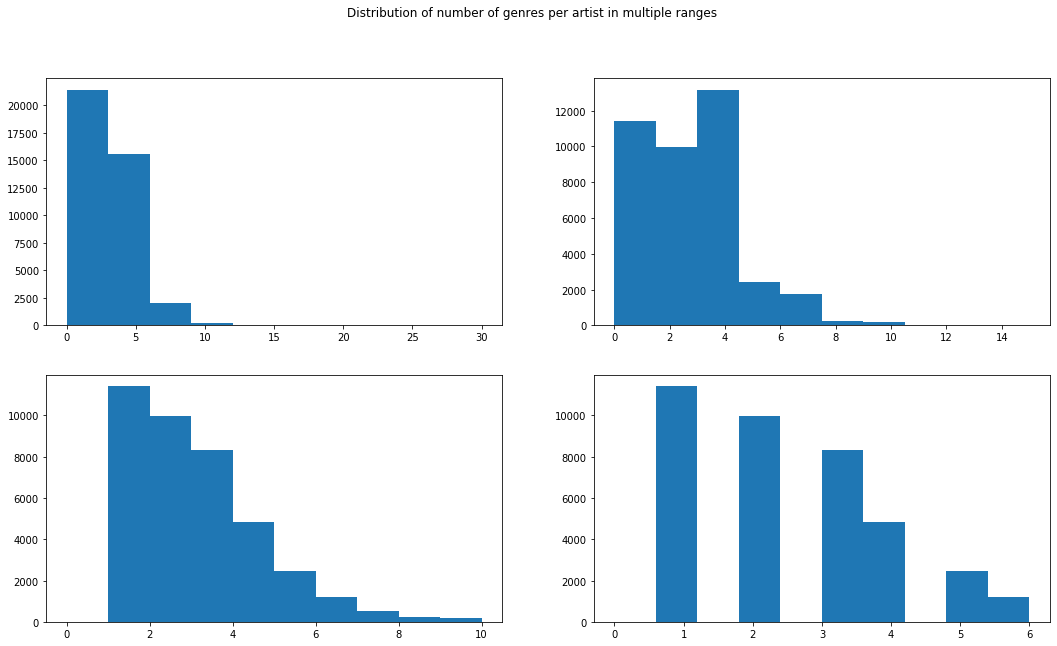

In [4]:
num_genres_per_artist = [np.sum(x[1:]) for x in genre_df.values]

fig = plt.figure(figsize=(18,10))
fig.subplots(2,2)
ranges = [(0,max(num_genres_per_artist)), (0, 15), (0, 10), (0, 6)]
for x in range(4):
    plt.subplot(2,2,x+1)
    plt.hist(num_genres_per_artist, range=ranges[x])
fig.suptitle("Distribution of number of genres per artist in multiple ranges")
plt.show()

In [8]:
G = nx.from_pandas_edgelist(graph_df, 'artist_name1', 'artist_name2')

print("The number of nodes in the graph is {}".format(len(list(G))))
print("The number of edges in the graph is {}".format(len(list(G.edges))))

The number of nodes in the graph is 39244
The number of edges in the graph is 73039


# Extra

Work only with those genres that have 10 or more artists associated with them

In [22]:
genre_df = pd.read_csv("genres.csv")
graph_df = pd.read_csv("graph.csv")

In [23]:
num_artist_per_genre = [genre_df[col].sum() for col in genre_df.columns[1:]]
num_genres_per_artist = [np.sum(x[1:]) for x in genre_df.values]

In [24]:
num_genres_less_than_10_artist = 0

for x in num_artist_per_genre:
    if x < 50:
        num_genres_less_than_10_artist += 1

print("The number of genres having less than 50 artist is {}".format(num_genres_less_than_10_artist))

The number of genres having less than 50 artist is 1065


In [25]:
columns_to_drop = []
for i, num in enumerate(num_artist_per_genre):
    if num < 50:
        columns_to_drop.append(genre_df.columns[i+1])
# print(columns_to_drop)
genre_df.drop(columns=columns_to_drop, inplace=True)

# Check if any artists are left with no genres
num_genres_per_artist = [np.sum(x[1:]) for x in genre_df.values]
zero_genre_artists = 0
for x in num_genres_per_artist:
    if x == 0:
        zero_genre_artists += 1
print("The number of artists left without a genre is: {}".format(zero_genre_artists))

The number of artists left without a genre is: 1321


In [26]:
rows_to_drop = []
for i, num in enumerate(num_genres_per_artist):
    if num <= 1:
        rows_to_drop.append(i)
# print(rows_to_drop)
no_genre_artists = [genre_df.iloc[x].artist_name for x in rows_to_drop]
genre_df.drop(index=rows_to_drop, inplace=True)
genre_df.reset_index(inplace=True)
genre_df.drop(columns=['index'], inplace=True)

# Check once more if there are any genres with one or no artists
num_artist_per_genre = [genre_df[col].sum() for col in genre_df.columns[1:]]
num_genres_1_artist = 0
num_genres_no_artist = 0

for x in num_artist_per_genre:
    if x <= 1:
        num_genres_1_artist += 1
    else:
        num_genres_no_artist += 1

print("The number of genres having 0 or 1 artist is {}".format(num_genres_1_artist))
print("The number of genres left is {}".format(num_genres_no_artist))

The number of genres having 0 or 1 artist is 0
The number of genres left is 252


In [27]:
for i, x in enumerate(graph_df.values):
    if x[0] in no_genre_artists or x[1] in no_genre_artists:
        graph_df.drop(index=i, inplace=True)
graph_df.reset_index(inplace=True)
graph_df.drop(columns=['index'], inplace=True)
display(graph_df)

,artist_name1,artist_name2
0,!!!,LCD Soundsystem
1,!!!,Maserati (band)
2,!!!,Out Hud
3,!!!,The Juan MacLean
4,!!!,Turing Machine (band)
...,...,...
39238,Škan,Skrew
39239,Škan,The Devil's Blood
39240,Žanil Tataj - Žak,Divlje jagode
39241,Željko Joksimović,Emina Jahović


In [28]:
# Update list of artist_names to match the names found in the graph 
artist_names = np.unique(list(graph_df.artist_name1.unique()) + list(graph_df.artist_name2.unique()))

# Make sure the genres table contains ONLY those artists that have a node in the graph 
genre_df = genre_df[genre_df.artist_name.isin(artist_names)]

# Create new genres table containing the artists that don't have a node in the graph, for future testing purposes
nodeless_genre_df = genre_df[~genre_df.artist_name.isin(artist_names)] # Empty table

print("Number of unique artist names after syncing the graph and the table is: {}".format(len(artist_names)))

genre_df.reset_index(inplace=True)
genre_df.drop(columns=['index'], inplace=True)

display(genre_df)
display(nodeless_genre_df)

Number of unique artist names after syncing the graph and the table is: 23272


,artist_name,a_cappella,acid_jazz,acid_rock,acoustic,acoustic_rock,adult_contemporary,afro_pop,afrobeat,alt_country,...,traditional_pop,trance,trap,trip_hop,uk_garage,underground_hip_hop,urban_contemporary_gospel,vocal_jazz,west_coast_hip_hop,world
0,!!!,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,'68 Comeback,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,'O' Level,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,'Til Tuesday,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,(We Are) Nexus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23267,Škan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23268,Žagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23269,Žanil Tataj - Žak,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23270,Željko Bebek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,artist_name,a_cappella,acid_jazz,acid_rock,acoustic,acoustic_rock,adult_contemporary,afro_pop,afrobeat,alt_country,...,traditional_pop,trance,trap,trip_hop,uk_garage,underground_hip_hop,urban_contemporary_gospel,vocal_jazz,west_coast_hip_hop,world


In [30]:
# Check once more if there are any genres with one or no artists
num_artist_per_genre = [genre_df[col].sum() for col in genre_df.columns[1:]]
num_genres_1_artist = 0

for x in num_artist_per_genre:
    if x < 50:
        num_genres_1_artist += 1

print("The number of genres with less than 50 artists is {}".format(num_genres_1_artist))

The number of genres with less than 50 artists is 31


In [31]:
genre_df.to_csv("genres_small.csv", index=False)
graph_df.to_csv("graph_small.csv", index=False)